In [40]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [41]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

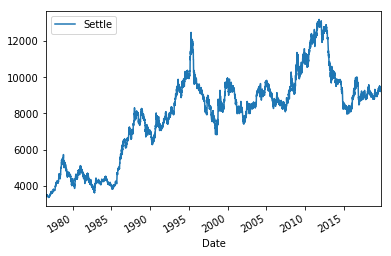

In [42]:
# Plot just the "Settle" column from the dataframe:

settlecolumngraph=yen_futures[["Settle"]].plot()


---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [43]:
import statsmodels.api as sm
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

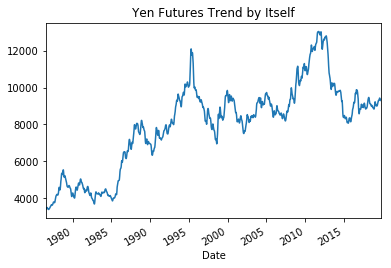

In [44]:
ts_trend.plot(title="Yen Futures Trend by Itself")

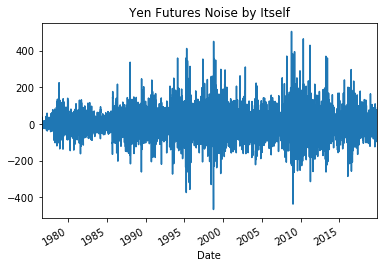

In [45]:
ts_noise.plot(title="Yen Futures Noise by Itself")

In [46]:
df_settle=yen_futures["Settle"]


In [47]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above
df_settletrend = pd.concat([yen_futures['Settle'], ts_trend],axis = 1,  join = 'inner')
df_settlenoise = pd.concat([yen_futures['Settle'], ts_noise],axis = 1,  join = 'inner')
df_settlenoisetrend = pd.concat([yen_futures['Settle'],ts_noise, ts_trend],axis = 1,  join = 'inner')

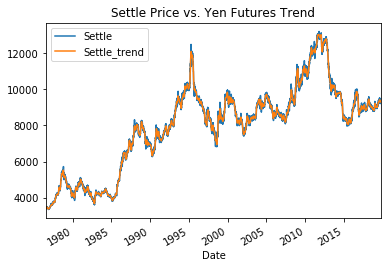

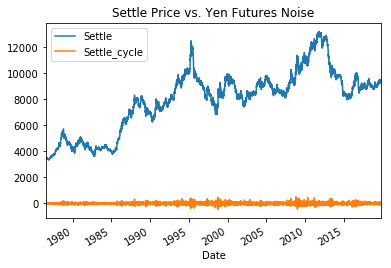

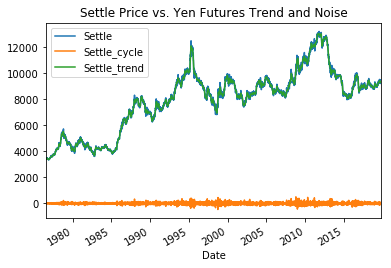

In [49]:
# Plot the Settle Price vs. the Trend for 2015 to the present
df_settletrend.plot(title="Settle Price vs. Yen Futures Trend")
df_settlenoise.plot(title="Settle Price vs. Yen Futures Noise")
df_settlenoisetrend.plot(title="Settle Price vs. Yen Futures Trend and Noise")
                   

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [50]:

from statsmodels.tsa.stattools import adfuller
stationarytest = adfuller(yen_futures["Settle"])



print('ADF Statistic: %f' % stationarytest[0])
print('p-value: %f' % stationarytest[1])
print('Critical Values:')
for key, value in stationarytest[4].items():
	print('\t%s: %.3f' % (key, value))
    

yen_stationary=yen_futures["Settle"].pct_change()
yen_stationary.replace(-np.inf, np.nan).dropna()
yen_stationarynow = yen_stationary.loc["1990-01-01":]

ADF Statistic: -1.953261
p-value: 0.307435
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


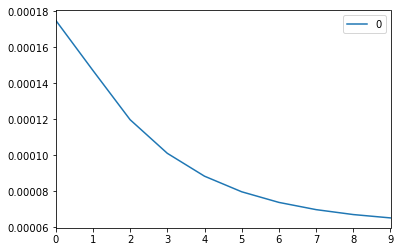

In [52]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
Yen_model = ARMA(yen_stationarynow.values, order=(2,1))
# Fit the model and assign it to a variable called results
Yen_results=Yen_model.fit()
pd.DataFrame(Yen_results.forecast(steps=10)[0]).plot()

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [53]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
Settle_returns=yen_futures[["Settle"]].dropna()
p=5
d=1
q=1
Settle_ARIMA=ARIMA(Settle_returns.values, order=(p,d,q))


results=Settle_ARIMA.fit()
results.summary()
# Settle_returns = Settle_ARIMA.Return
# Fit the model
#Settle_Results=Settle_ARIMA.fit()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Tue, 30 Mar 2021   AIC                         119245.144
Time:                        17:35:57   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5347      0.526      1.017      0.309      -0.495       1.565
ar.L1.D.y      0.2256      0.595      0.379      0.705      -0.941       1.393
ar.L2.D.y     -0.0026      0.012     -0.223      0.823      -0.025       0.020
ar.L3.D.y     -0.0061      0.010     -0.594      0.552      -0.026       0.014
ar.L4.D.y     -0.0133      0.011     -1.244      0.213      -0.034       0.008
ar.L5.D.y     -0.0024      0.014     -0.179      0.858      -0.029       0.024
ma.L1.D.y     -0.2360      0.595     -0.396      0.692      -1.403       0.931
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9127           -1.4196j            2.3820           -0.1016
AR.2            1.9127           +1.4196j            2.3820            0.1016
AR.3           -1.7078           -3.0607j            3.5049           -0.3310
AR.4           -1.7078           +3.0607j            3.5049            0.3310
AR.5           -5.8608           -0.0000j            5.8608           -0.5000
MA.1            4.2373           +0.0000j            4.2373            0.0000
-----------------------------------------------------------------------------
"""

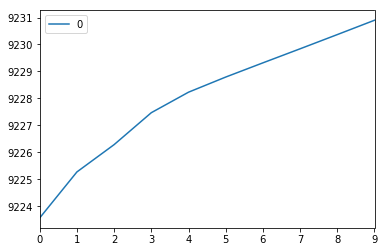

In [57]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=10)[0]).plot()

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [69]:
#from arch import arch_model
import numpy as np
import arch

In [78]:
#np.random.random(size=(10)) 
GARCH_model = arch.arch_model(Settle_returns, mean="Zero", vol="GARCH", p=2, q=1)
result=GARCH_model.fit()
#returns = model.loc['2008':'2016']
#returns = returns.dropna()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 359626.0317743472
Iteration:      2,   Func. Count:     13,   Neg. LLF: 112830.82583182675
Iteration:      3,   Func. Count:     18,   Neg. LLF: 112830.60979541624
Iteration:      4,   Func. Count:     23,   Neg. LLF: 112830.29839476969
Iteration:      5,   Func. Count:     28,   Neg. LLF: 112830.05170907875
Iteration:      6,   Func. Count:     33,   Neg. LLF: 112829.97196144382
Iteration:      7,   Func. Count:     38,   Neg. LLF: 112829.96606696522
Iteration:      8,   Func. Count:     43,   Neg. LLF: 112829.96590630672
Iteration:      9,   Func. Count:     47,   Neg. LLF: 112829.9659063562
Optimization terminated successfully    (Exit mode 0)
            Current function value: 112829.96590630672
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


C:\Users\Scott Alexander\anaconda\envs\dev\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.544e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [79]:
last_day = Settle_returns.index.max().strftime('%Y-%m-%d')
print(last_day)

2019-10-15


In [80]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = result.forecast(start=last_day, horizon=forecast_horizon)

C:\Users\Scott Alexander\anaconda\envs\dev\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [82]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,145391.955044,144422.52673,143475.509952,142550.50831,141647.109845


In [83]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,145391.955044
h.2,144422.526730
h.3,143475.509952
h.4,142550.508310
h.5,141647.109845


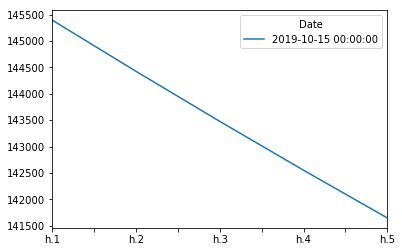

In [84]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

In [1]:
print("This is a poor model to rely on according to the P values given by the ARMA and ARIMA and the GARCH calculations. Also, according to the forecasting, the Yen is expected to decrease. So I would not buy the Yen now.")

This is a poor model to rely on according to the P values given by the ARMA and ARIMA and the GARCH calculations. Also, according to the forecasting, the Yen is expected to decrease. So I would not buy the Yen now.
